In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import calendar

In [2]:
appointments = pd.read_csv("appointments.csv")
billing = pd.read_csv("billing.csv")
doctors = pd.read_csv("doctors.csv")
patients = pd.read_csv("patients.csv")
treatments = pd.read_csv("treatments.csv")

In [3]:
for df in [appointments, billing, doctors, patients, treatments]:
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)

appointments['appointment_date'] = pd.to_datetime(appointments['appointment_date'])
billing['bill_date'] = pd.to_datetime(billing['bill_date'])

In [4]:
merged = appointments.merge(patients, on="patient_id") \
                     .merge(treatments, on="appointment_id") \
                     .merge(billing, on="treatment_id") \
                     .merge(doctors, on="doctor_id")

print("Final merged data sample:\n", merged.head())

Final merged data sample:
   appointment_id patient_id_x doctor_id appointment_date appointment_time  \
0           A001         P034      D009       2023-08-09         15:15:00   
1           A002         P032      D004       2023-06-09         14:30:00   
2           A003         P048      D004       2023-06-28          8:00:00   
3           A004         P025      D006       2023-09-01          9:15:00   
4           A005         P040      D003       2023-07-06         12:45:00   

  reason_for_visit     status first_name_x last_name_x gender  ...   amount  \
0          Therapy  Scheduled         Alex       Smith      F  ...  3941.97   
1          Therapy    No-show         Alex       Moore      M  ...  4158.44   
2     Consultation  Cancelled        Emily      Miller      M  ...  3731.55   
3     Consultation  Cancelled       Robert      Wilson      M  ...  4799.86   
4        Emergency    No-show        Emily    Williams      M  ...   582.05   

   payment_method payment_status fi

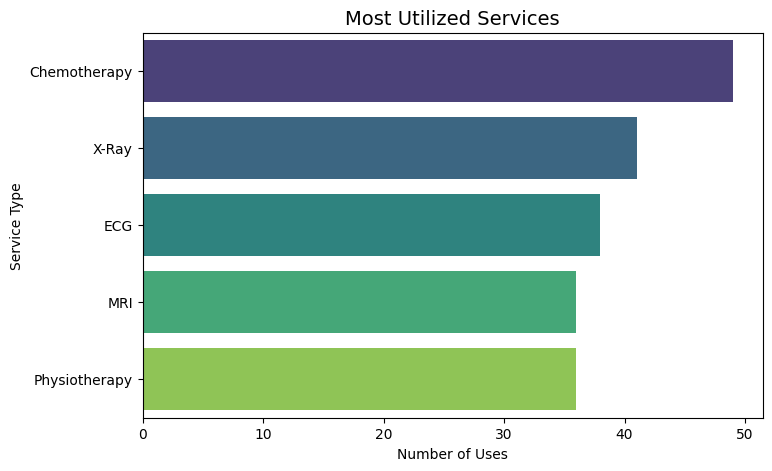

In [5]:
service_usage = merged['treatment_type'].value_counts().head(8)

plt.figure(figsize=(8,5))
sns.barplot(x=service_usage.values, y=service_usage.index, palette="viridis", hue=service_usage.index, dodge=False, legend=False)
plt.title("Most Utilized Services", fontsize=14)
plt.xlabel("Number of Uses")
plt.ylabel("Service Type")
plt.show()

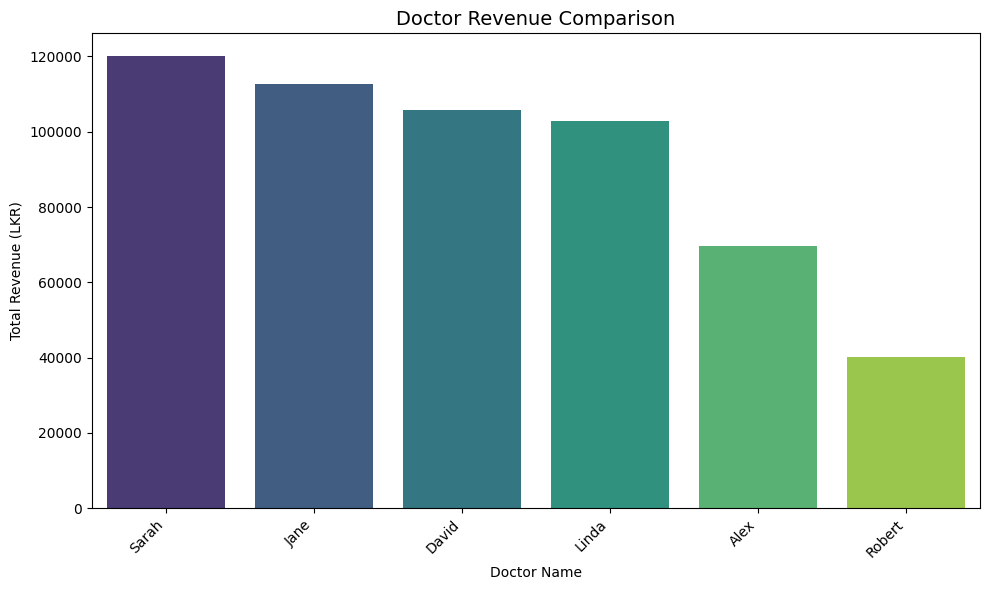

In [6]:
doc_perf = merged.groupby("first_name_y").agg(
    revenue=("amount", "sum")
).reset_index().sort_values("revenue", ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(data=doc_perf, x="first_name_y", y="revenue", palette="viridis", hue="first_name_y",dodge=False, legend=False)
plt.title("Doctor Revenue Comparison", fontsize=14)
plt.xlabel("Doctor Name")
plt.ylabel("Total Revenue (LKR)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

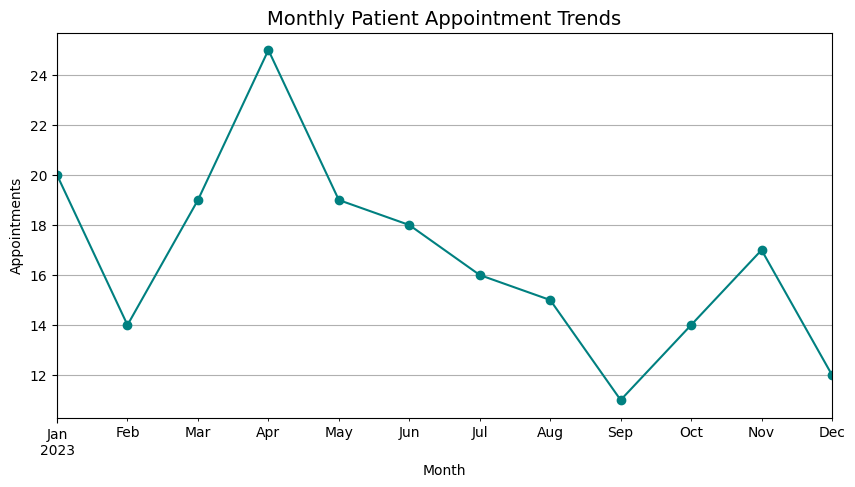

In [7]:
monthly = merged.set_index("appointment_date").resample("ME")["appointment_id"].count()

plt.figure(figsize=(10,5))
monthly.plot(marker="o", color="teal")
plt.title("Monthly Patient Appointment Trends", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Appointments")
plt.grid(True)
plt.show()


Patient Behavior (sample):
              visits   avg_spend    fav_service
patient_id_x                                   
P001               4  1929.76750   Chemotherapy
P002               3  1989.58000   Chemotherapy
P003               2  3968.44000            MRI
P004               2  2681.25500            ECG
P005               8  2326.23875  Physiotherapy


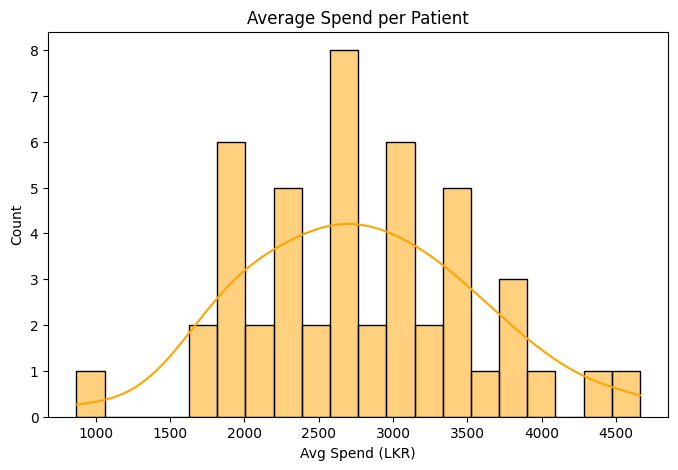

In [8]:
patient_behavior = merged.groupby("patient_id_x").agg(
    visits=("patient_id_x","count"),
    avg_spend=("amount","mean"),
    fav_service=("treatment_type", lambda x: x.mode()[0] if not x.mode().empty else "N/A")
)

print("\nPatient Behavior (sample):")
print(patient_behavior.head())

plt.figure(figsize=(8,5))
sns.histplot(patient_behavior['avg_spend'], bins=20, kde=True, color="orange")
plt.title("Average Spend per Patient")
plt.xlabel("Avg Spend (LKR)")
plt.show()

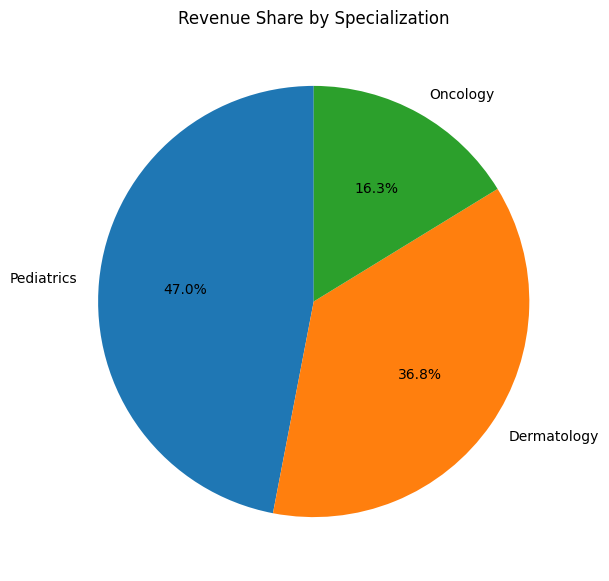

In [9]:
revenue_dept = merged.groupby("specialization")["amount"].sum().sort_values(ascending=False)

plt.figure(figsize=(7,7))
plt.pie(revenue_dept, labels=revenue_dept.index, autopct="%.1f%%", startangle=90)
plt.title("Revenue Share by Specialization")
plt.show()

Appointment Prediction R²: 0.344, RMSE: 3.00

APPOINTMENT PREDICTION FOR NEXT 2 MONTHS
           Month  Predicted_Appointments
0   January 2024                      13
1  February 2024                      12


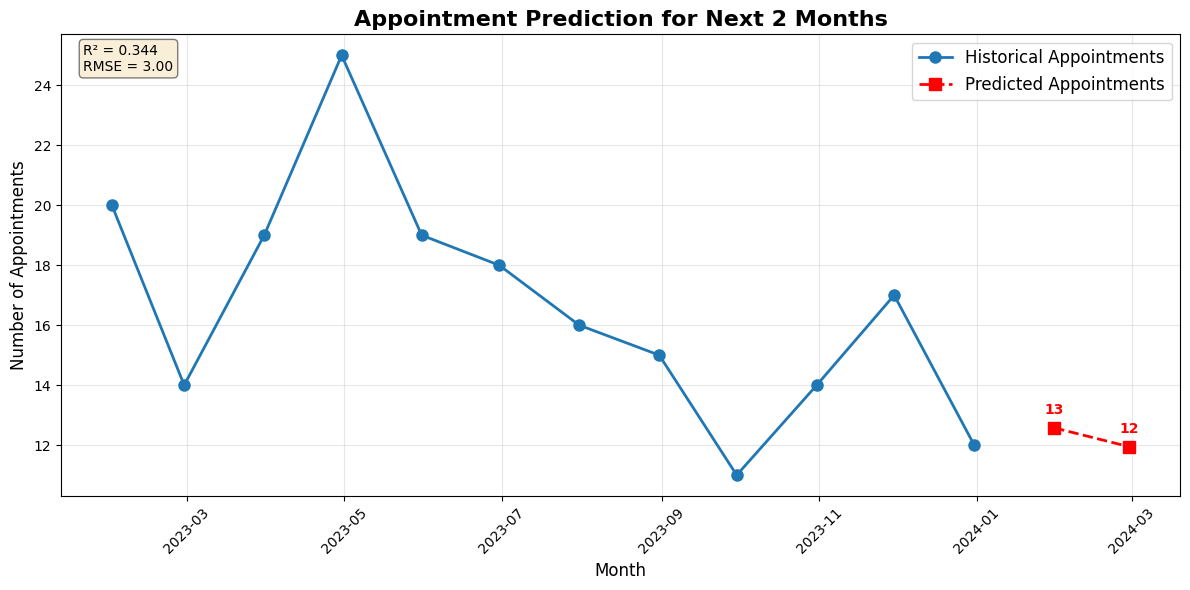

In [10]:
# Prepare monthly appointment data
monthly_appointments = merged.set_index("appointment_date").resample("ME")["appointment_id"].count()

# Create time features
def create_time_features(df):
    df = df.reset_index()
    datetime_col = df.columns[0]
    df['month'] = df[datetime_col].dt.month
    df['year'] = df[datetime_col].dt.year
    df['time_index'] = range(1, len(df) + 1)
    df.rename(columns={datetime_col: 'date'}, inplace=True)
    return df

appointments_df = create_time_features(monthly_appointments.to_frame(name='appointments'))

# Predict next 2 months
def predict_next_months(df, target_col, n_months=2):
    X = df[['time_index']]
    y = df[target_col]

    model = LinearRegression()
    model.fit(X, y)

    last_index = df['time_index'].max()
    future_indices = pd.DataFrame({'time_index': [last_index + i for i in range(1, n_months + 1)]})
    predictions = model.predict(future_indices)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    return predictions, r2, rmse, model

# Run prediction
appointment_predictions, appointment_r2, appointment_rmse, model = predict_next_months(appointments_df, 'appointments')

# Generate future months
last_date = appointments_df['date'].max()
future_months = [last_date + pd.DateOffset(months=i) for i in range(1, 3)]

# Display results
prediction_summary = pd.DataFrame({
    'Month': [f"{calendar.month_name[date.month]} {date.year}" for date in future_months],
    'Predicted_Appointments': [round(pred) for pred in appointment_predictions]
})

print(f"Appointment Prediction R²: {appointment_r2:.3f}, RMSE: {appointment_rmse:.2f}")
print("\n" + "="*50)
print("APPOINTMENT PREDICTION FOR NEXT 2 MONTHS")
print("="*50)
print(prediction_summary)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(appointments_df['date'], appointments_df['appointments'], 
         'o-', linewidth=2, markersize=8, label='Historical Appointments')

# Plot predicted data
plt.plot(future_months, appointment_predictions, 
         's--', color='red', linewidth=2, markersize=8, label='Predicted Appointments')

# Add value annotations for predictions
for i, (date, value) in enumerate(zip(future_months, appointment_predictions)):
    plt.annotate(f'{int(round(value))}', 
                 (date, value), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontweight='bold',
                 color='red')

# Format the plot
plt.title('Appointment Prediction for Next 2 Months', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add prediction metrics to the plot
textstr = f'R² = {appointment_r2:.3f}\nRMSE = {appointment_rmse:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()